# TP3

Elaborado por: Alan Churichi

In [1]:
%load_ext lab_black

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`.

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.
   
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del item 2.
   
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

Cargamos las imagenes a procesar.

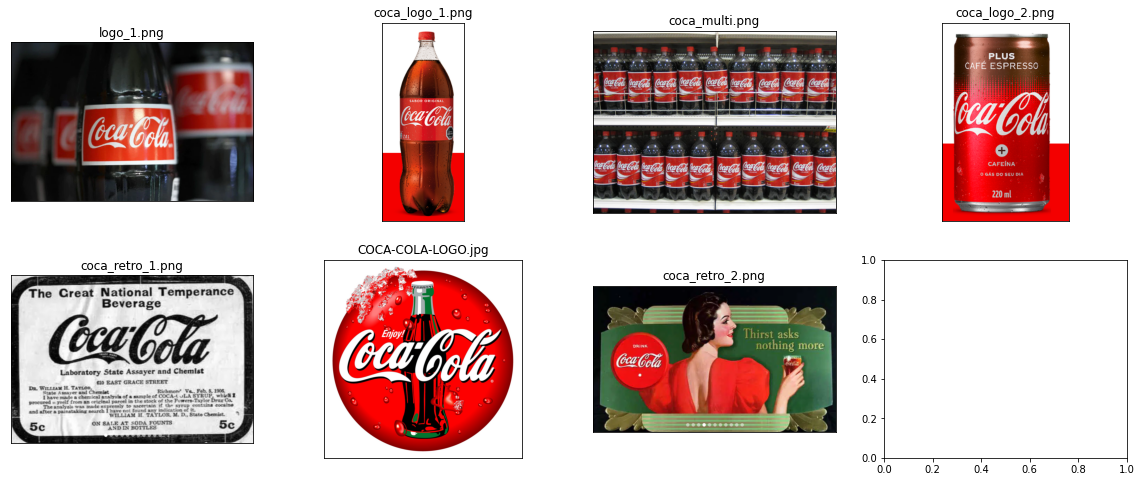

In [2]:
def load_image(path, filename, grayscale=False):
    flags = {"flags": cv.IMREAD_GRAYSCALE} if grayscale else {}
    img = cv.imread(os.path.join(path, filename), **flags)
    if grayscale:
        return img
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)


base_path = "/tf/notebooks/CEIA/computer-vision-1/tp3/assets"
images_path = os.path.join(base_path, "images")

filenames = os.listdir(images_path)
images = [load_image(images_path, filename) for filename in filenames]

_, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(2):
    for j in range(4):
        idx = i * 4 + j
        if idx < 7:
            axes[i][j].imshow(images[idx])
            axes[i][j].title.set_text(filenames[idx])
            axes[i][j].xaxis.set_visible(False)
            axes[i][j].yaxis.set_visible(False)

Cargamos el template que utilizaremos.

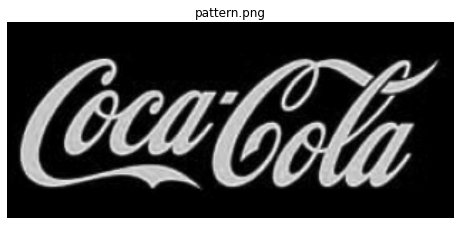

In [3]:
template_path = os.path.join(base_path, "template")

template_black_logo = load_image(template_path, "pattern.png", grayscale=True)
template = cv.bitwise_not(template_black_logo)
# template = template_black_logo

plt.figure(figsize=(8, 8))
plt.imshow(template, cmap="gray")
plt.axis("off")
plt.title("pattern.png")
plt.show()

A continuación cargamos la imagen 'fft_alfa_pred.png' en escala de grises y le aplicamos filtros gausianos generados distintos tamaños de kernel y desviación estándar.

In [ ]:
def generate_pyramid(img, limits=10):
    pyramid = []

    scale_down = np.linspace(0, 1, limits, endpoint=False)[1:]
    scale_up = np.array([i for i in range(1, limits + 1)])
    scales = np.concatenate((scale_down, scale_up))
    (h, w) = img.shape

    for scale in scales:
        if scale == 1:
            pyramid.append(img)
        else:
            pyramid.append(
                cv.resize(
                    img,
                    (round(w * scale), round(h * scale)),
                    interpolation=cv.INTER_AREA if scale < 1 else cv.INTER_CUBIC,
                )
            )

    return pyramid

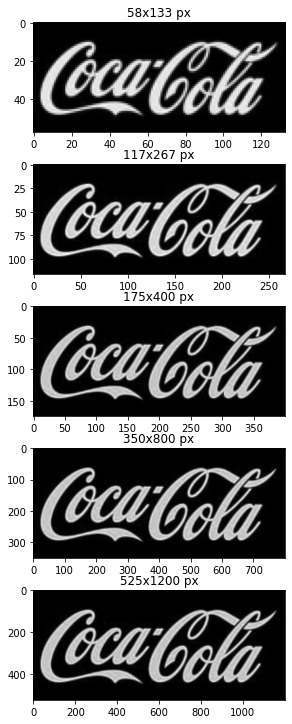

In [24]:
pyramid = generate_pyramid(template, 3)

_, axes = plt.subplots(len(pyramid), figsize=(10, 10))
plt.tight_layout()
for i in range(len(pyramid)):
    img = pyramid[i]
    axes[i].imshow(img, cmap="gray")
    axes[i].title.set_text(f"{img.shape[0]}x{img.shape[1]} px")

In [27]:
GREEN_COLOR = (0, 255, 0)


def match_template(img, template, title="", method=cv.TM_CCOEFF_NORMED):
    template_pyramid = generate_pyramid(template, 10)

    img_rgb = img.copy()
    img_gray = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)

    results = []
    for template_scaled in template_pyramid:
        # w, h = template.shape[::-1]
        max_val = 0
        x = 0
        y = 0
        try:
            res = cv.matchTemplate(img_gray, template_scaled, method)
            _, max_val, _, max_loc = cv.minMaxLoc(res)
            (x, y) = max_loc
        except:
            pass
        results.append((max_val, x, y))

    # cv.rectangle(img_rgb, (x, y), (x + w, y + h), GREEN_COLOR, 3)
    # cv.putText(
    #     img_rgb,
    #     f"{max_val:.4f}",
    #     (x, y - 10),
    #     cv.FONT_HERSHEY_SIMPLEX,
    #     0.9,
    #     GREEN_COLOR,
    #     2,
    # )
    # plt.figure(figsize=(8, 8))
    # plt.imshow(img_rgb)
    # plt.axis("off")
    # plt.title(title)
    # plt.show()

    return results
    # (x, y) = max_loc

    # cv.rectangle(img_rgb, (x, y), (x + w, y + h), GREEN_COLOR, 3)
    # cv.putText(
    #     img_rgb,
    #     f"{max_val:.4f}",
    #     (x, y - 10),
    #     cv.FONT_HERSHEY_SIMPLEX,
    #     0.9,
    #     GREEN_COLOR,
    #     2,
    # )
    # plt.figure(figsize=(8, 8))
    # plt.imshow(img_rgb)
    # plt.axis("off")
    # plt.title(title)
    # plt.show()


match_template(images[0], template, filenames[0])

[(0.5558839440345764, 151, 188),
 (0.4818262457847595, 120, 179),
 (0.4133605360984802, 558, 222),
 (0.34330105781555176, 522, 209),
 (0.2961966395378113, 461, 30),
 (0.25828686356544495, 258, 206),
 (0.43200796842575073, 201, 193),
 (0.34971603751182556, 185, 184),
 (0.24875593185424805, 127, 170),
 (0.2678297460079193, 97, 147),
 (0, 0, 0),
 (0.25430768728256226, 0, 63),
 (0.21408669650554657, 423, 72),
 (0.28288668394088745, 1112, 385),
 (0.298221617937088, 1710, 32),
 (0.3097487986087799, 1196, 194),
 (0.36039698123931885, 1392, 268),
 (0.3845694959163666, 1603, 333),
 (0.3880689740180969, 171, 271)]

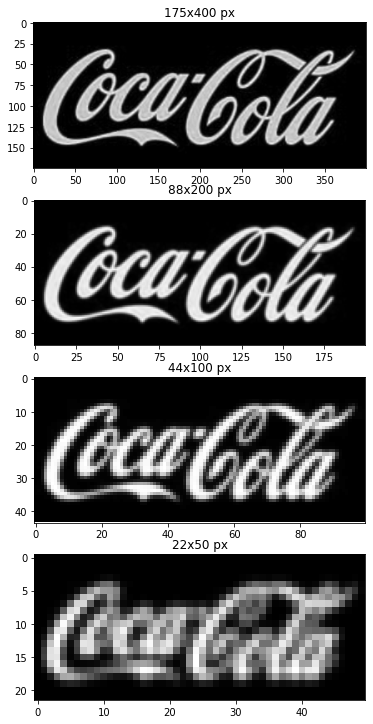

In [4]:
def generate_pyramid(img, num_iterations, scale_up=False):
    pyramid = [img]
    for _ in range(num_iterations):
        pyramid.append(cv.pyrUp(pyramid[-1]) if scale_up else cv.pyrDown(pyramid[-1]))
    return pyramid


pyramid_down = generate_pyramid(template, 3)

_, axes = plt.subplots(4, figsize=(10, 10))
plt.tight_layout()
for i in range(4):
    img = pyramid_down[i]
    axes[i].imshow(img, cmap="gray")
    axes[i].title.set_text(f"{img.shape[0]}x{img.shape[1]} px")

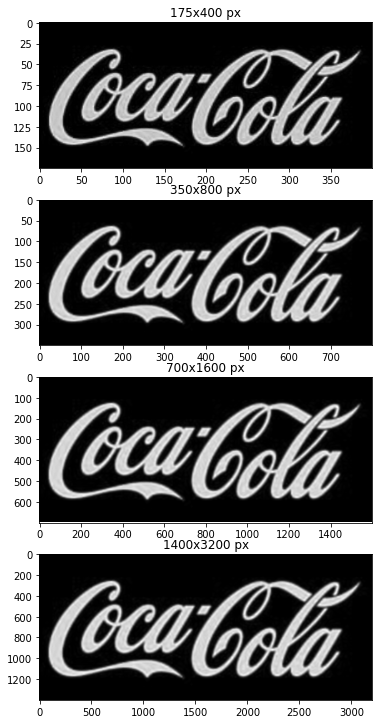

In [5]:
pyramid_up = generate_pyramid(template, 3, scale_up=True)

_, axes = plt.subplots(4, figsize=(10, 10))
plt.tight_layout()
for i in range(4):
    img = pyramid_up[i]
    axes[i].imshow(img, cmap="gray")
    axes[i].title.set_text(f"{img.shape[0]}x{img.shape[1]} px")

In [28]:
GREEN_COLOR = (0, 255, 0)


def match_template2(img, template, title="", method=cv.TM_CCOEFF_NORMED):
    img_rgb = img.copy()
    # img_gray = cv.bitwise_not(cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY))
    img_gray = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)
    w, h = template.shape[::-1]
    res = cv.matchTemplate(img_gray, template, method)
    _, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        (x, y) = min_loc
    else:
        (x, y) = max_loc
    cv.rectangle(img_rgb, (x, y), (x + w, y + h), GREEN_COLOR, 3)
    cv.putText(
        img_rgb,
        f"{max_val:.4f}",
        (x, y - 10),
        cv.FONT_HERSHEY_SIMPLEX,
        0.9,
        GREEN_COLOR,
        2,
    )
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [29]:
match_template2(images[0], pyramid_down[0], filenames[0])

NameError: name 'pyramid_down' is not defined

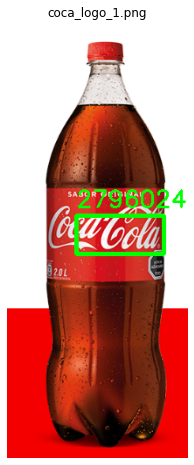

In [54]:
match_template(images[1], pyramid_down[2], filenames[1], method=cv.TM_CCOEFF)

0.5385788679122925
0.53857887


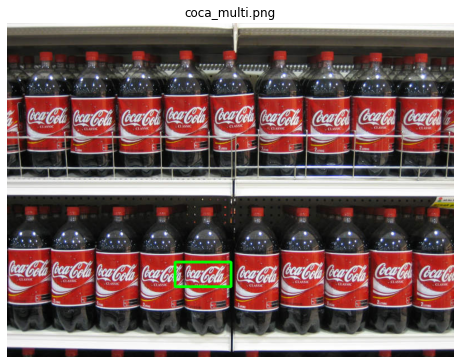

In [33]:
match_template(images[2], pyramid_down[2], filenames[2])

7676728.0
7676728.0


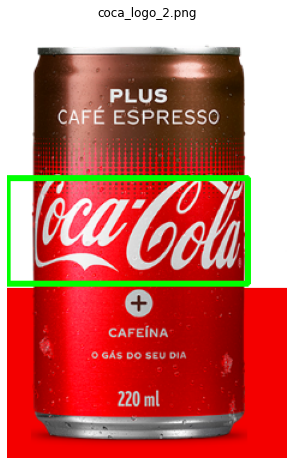

In [34]:
match_template(images[3], pyramid_down[1], filenames[3], method=cv.TM_CCOEFF)

0.2711469531059265
0.27114695


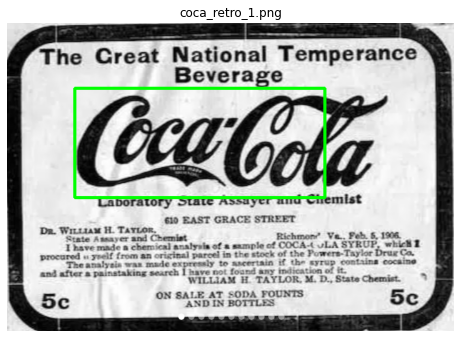

In [35]:
match_template(images[4], template_black_logo, filenames[4])

0.250322163105011
0.25032216


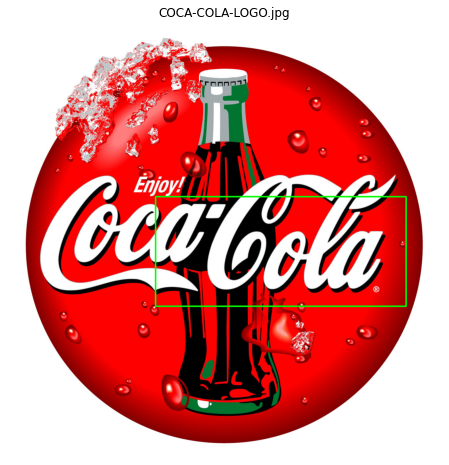

In [36]:
match_template(images[5], pyramid_up[1], filenames[5])

1.0


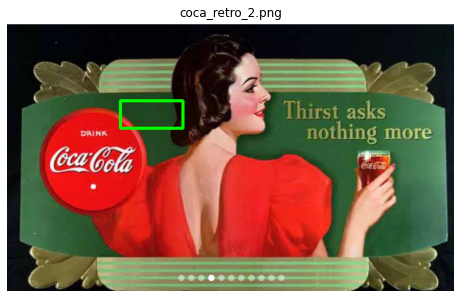

In [13]:
pyramid_down_black = generate_pyramid(template_black_logo, 3)

match_template(images[6], pyramid_down[2], filenames[6], method=cv.TM_SQDIFF_NORMED)

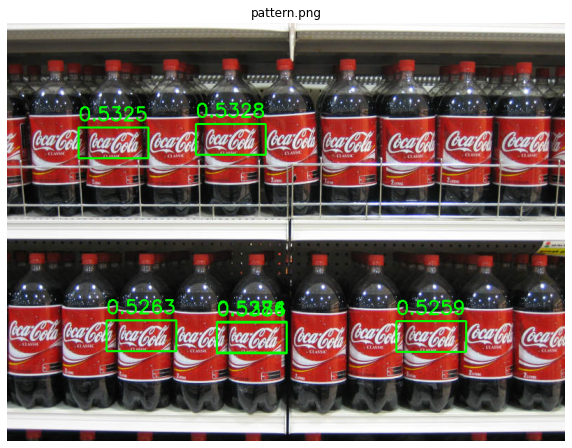

In [26]:
img_rgb = images[2].copy()
img_gray = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)
template = pyramid_down[2]
w, h = template.shape[::-1]
res = cv.matchTemplate(img_gray, template, cv.TM_CCOEFF_NORMED)
# (minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(res)
# print((maxVal + 1) / 2)
threshold = 0.525
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):
    (x, y) = pt
    score = res[y, x]
    cv.rectangle(img_rgb, (x, y), (x + w, y + h),GREEN_COLOR, 2)
    cv.putText(
        img_rgb,
        f"{score:.4f}",
        (x, y - 10),
        cv.FONT_HERSHEY_SIMPLEX,
        0.9,
       GREEN_COLOR,
        2,
    )
    # x,y,w,h = cv2.boundingRect(contour)
    # image = cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 1)
    # cv2.putText(image, 'Fedex', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("pattern.png")
plt.show()